# Introduction


This notebook attempts to create a workflow that; given an audio file, it separates it into different audio components, splits it into 6-seconds sections and cleans these sections. Further, it presents these sections to an ML model.
The model then gives inferences on these sections and the most popular prediction is presented as the label for the original audio file.

# Mount the directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls '{main_dir}'/.

Mounted at /content/gdrive
All_Data  Csv_Files	 Helper_Notebooks  Models
Audios	  Documentation  Main_Notebooks




# Install and import Libraries

In [2]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [3]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile
!pip install -q -U keras-tuner
!pip install -q ffmpeg
!pip install -q spleeter

     |████████████████████████████████| 23.1 MB 1.3 MB/s 
     |████████████████████████████████| 98 kB 5.8 MB/s 
     |████████████████████████████████| 51 kB 5.6 MB/s 
     |████████████████████████████████| 77 kB 2.6 MB/s 
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 183 kB 64.0 MB/s 
     |████████████████████████████████| 4.0 MB 48.6 MB/s 
     |████████████████████████████████| 462 kB 60.1 MB/s 
     |████████████████████████████████| 1.2 MB 30.5 MB/s 
     |████████████████████████████████| 132 kB 61.1 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 57 kB 4.1 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.2 MB/s 
     |████████████████████████████████| 3.3 MB 49.9 MB/s 
     |██████████████████████

In [34]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import keras_tuner as kt
from ast import literal_eval
from joblib import load, dump
from pathlib import Path

import os
import sys
import time
import shutil

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Model Paths and MetaData

In [5]:
# audio file and audio processing directory
spleeting_dir = main_dir + 'All_Data/serving_data/'
audio_file = spleeting_dir + 'testing_audio/Kerstin Thorborg/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M.wav'
# audio_file = spleeting_dir + 'Maureen Forster/Zwei Gesänge, Op. 91 - Geistliches Wiegenlied-GEUAB_9vMxQ.wav'


# mfccs files
Females_mfccs_file = main_dir + "Csv_Files/females_mfccs.csv"
Males_mfccs_file = main_dir + "Csv_Files/males_mfccs.csv"
# label_target mapping
females_label_target = {('mezzosoprano dramatic', 3), ('contraltos', 0), ('soprano coloratura', 5), 
                ('soprano spinto', 9), ('soprano lyric', 7), ('mezzosoprano lyric', 4), ('mezzosoprano coloratura', 2),
                ('soprano dramatic', 6), ('soprano soubrette', 8), ('countertenor', 1)}

males_label_target = {('baritone_bassbaritones', 0), ('baritone_dramatic', 1), ('baritone_lyric', 2), 
                ('tenor_spinto', 8), ('bass_dramatic', 4), ('bass_cantante', 3), ('tenor_leggero', 6), 
                ('tenor_lyric', 7), ('tenor_dramatic', 5)}
# Models
model_names = ['Males_A', 'Males_B', 'Females_A', 'Females_B']
models = [dict({'pca_model_path': "Models/Production/{0}/PCA/{0}_pca.joblib".format(model_name),
    'scaler_model_path': "Models/Production/{0}/Scaler/{0}_scaler.joblib".format(model_name),
    'label_mapping_path': "Models/Production/{0}/Reports/{0}_label_mapping.joblib".format(model_name),
    'keras_model_dir_path': "Models/Production/{0}/ANN/{0}".format(model_name)}) for model_name in model_names]

Males_A = models[0]
Males_B = models[1]
Females_A = models[2]
Females_B = models[3]

# Add models
meta_paths = [main_dir + model[path] for model in models for path in model]
# add all other paths
meta_paths.extend([spleeting_dir, Males_mfccs_file, Females_mfccs_file, audio_file])

# check if all models and essential paths are present before proceeding
for item in meta_paths:
  if os.path.exists(item)==False:
    print("Path '{}' does not exist. Do not proceed".format(item))
    break
  else:
    print("Path '{}' exists: OK".format(item))

# user to select the prevalent gender of the artist voice in the audio file.
[female_models, male_models] = [[Females_A, Females_B], [Males_A, Males_B]]
selected_models = female_models

Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/PCA/Males_A_pca.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/Scaler/Males_A_scaler.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/Reports/Males_A_label_mapping.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/ANN/Males_A' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_B/PCA/Males_B_pca.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_B/Scaler/Males_B_scaler.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_B/Reports/Males_B_label_mapping.joblib' exists: OK
Path '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_B/ANN/Males_B' exists: OK
Path '/content/gdrive/

In [17]:
print(main_dir + Males_A['label_mapping_path'])
label_mapping = load(main_dir + Males_A['scaler_model_path'])
print(label_mapping)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/Reports/Males_A_label_mapping.joblib
StandardScaler()


#Separating audio components using Spleeter

Load and visualize the data

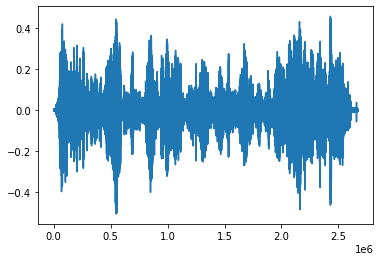

In [10]:
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    wav, sample_rate = librosa.load(filename)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav.numpy()

wav = load_wav_16k_mono(audio_file)
plt.figure()
plt.plot(wav)

Spleeting into components

In [ ]:

def spleet_file_into_components(audio_file_path, dest_dir = spleeting_dir):
  """
  Funtion splits a file into the various components: bass, vocals, drums, piano and other

  Function takes in the audio file path, moves it to the spleeter working directory then separates 
  it into the components in output directory.
  
  """
  #copy to the speeting directory
  audio_file_name = r"{}".format(os.path.basename(audio_file_path))
  # print(str(audio_file_name))
  src_dir = os.path.dirname(audio_file_path)
  dest_dir = spleeting_dir
  print("Moving file to new directory...")
  shutil.copy2(audio_file_path, dest_dir)

  #change the current working directory
  os.chdir(dest_dir)

  #spleet into components
  print("Spleeting files into components...")
  !spleeter separate -p spleeter:2stems -o output_dir '{audio_file_name}'
  
  #discard the copied files
  print("Discarding copied files...")
  for item in os.listdir(dest_dir):
    if item.endswith('.wav'):
      os.remove(dest_dir + '/{}'.format(item))
  
  os.chdir('/content')

  pass

spleet_file_into_components(audio_file)

Moving file to new directory...
Spleeting files into components...
INFO:spleeter:File output_dir/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M/vocals.wav written succesfully
INFO:spleeter:File output_dir/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M/accompaniment.wav written succesfully
Discarding copied files...


In [ ]:
# Delete all other components
separated_components_dir = r"{0}output_dir/{1}".format(spleeting_dir,os.path.basename(audio_file).rsplit('.', 1)[0])
for file_name in os.listdir(separated_components_dir):
  if file_name.startswith(("accompaniment"))==True:
    removed_file = separated_components_dir +'/'+ file_name
    os.remove(removed_file)
    print('Removed file: ', removed_file)
    
# Zwei Gesänge, Op. 91 - Geistliches Wiegenlied-GEUAB_9vMxQ
# Rename the vocals.wav file to the original
for file_name in os.listdir(separated_components_dir):
  if file_name.startswith(("vocals"))==True:
    src_path = '{}/{}'.format(separated_components_dir, file_name)
    dest_path = '{}/{}.wav'.format(separated_components_dir, os.path.basename(separated_components_dir))
    os.rename(src_path, dest_path)
    print("Vocals File renamed")
  else:
    print("No vocals file to rename")  

Removed file:  /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/serving_data/output_dir/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M/accompaniment.wav
No vocals file to rename
Vocals File renamed


In [ ]:
# Remove silent body parts
separated_components_dir = r"{0}output_dir/{1}".format(spleeting_dir,os.path.basename(audio_file).rsplit('.', 1)[0])
separated_components_dir = r"{0}output_dir/{1}".format(spleeting_dir,os.path.basename(audio_file).rsplit('.', 1)[0])
for item in os.listdir(separated_components_dir):
  if os.path.isdir(separated_components_dir + '/' + item):
    shutil.rmtree(separated_components_dir + '/' + item)

for item in os.listdir(separated_components_dir):
  if os.path.isfile(separated_components_dir + '/' + item):
    m_input = separated_components_dir + '/' + item
    final_audio = separated_components_dir + '/' + item
    m_output = separated_components_dir + '/'  + item.rsplit('.')[0] + '_silence_removed.wav'

    !ffmpeg -i '{m_input}' -af silenceremove=stop_periods=-1:stop_duration=1:stop_threshold=-60dB '{m_output}'

    os.remove(m_input)
    os.rename(m_output, final_audio)
    print('Periods of silence removed')


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Creating six second splits from vocals

In [ ]:
def split_into_six_seconds(audio_file_path, desired_time):
  '''
  This function takes in an audio file path and splits that audio into six-second parts

  1. Change to the directory of the file to be split.

  2. Split the file

  3. Discard those that are less than six seconds

  '''

  dir_name = os.path.basename(audio_file_path).rsplit('.', 1)[0]
  file_name = os.path.basename(audio_file_path)

  splitting_dir = r"{0}output_dir/{1}".format(spleeting_dir, dir_name )
  file_path = r"{0}output_dir/{1}/{2}".format(spleeting_dir,dir_name, file_name)

  if os.path.isfile(audio_file_path)==False:
    pass
  
  if os.getcwd()!= splitting_dir:                        # change the working directory
    os.chdir(splitting_dir)

  segmented_dir = dir_name + '_segmented/'
  segmented_file_name = r"{0}{1}_%03d.wav".format(segmented_dir, dir_name)

  if os.path.exists(segmented_dir)==True:
    for existing_file in os.listdir(segmented_dir):
      os.remove(segmented_dir + '/' + existing_file)
      print('removing', segmented_dir + '/' + existing_file)
    os.rmdir(segmented_dir)
    print("Deleted existing directory...")
    os.mkdir(segmented_dir)
    print("Creating new directory to store segmented files...")
  else:
    os.mkdir(segmented_dir)
    print("Created new directory to store segmente files...")
    

  !ffmpeg -i '{file_name}' -f segment -segment_time '{desired_time}' -c copy '{segmented_file_name}'

  #clean up
  for item in os.listdir(segmented_dir):
    audio_length = librosa.get_duration(filename=segmented_dir + item)
    if audio_length<(desired_time-0.02):
      os.remove(segmented_dir + item)
      print("Removed {} because audio length of {} is less than {}". format(item, audio_length, desired_time ))

  os.remove(file_path)
  pass


vocals_file =  r"{0}output_dir/{1}/{2}".format(spleeting_dir,os.path.basename(audio_file).rsplit('.', 1)[0],os.path.basename(audio_file))
print(vocals_file)
split_into_six_seconds(vocals_file, desired_time = 6)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/serving_data/output_dir/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M/Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M.wav
Created new directory to store segmente files...
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable

# Data Transform (MFCCs generation, PCA model transform)

MFCCs transform

In [11]:
def extract_features(file_name):
  audio, sample_rate = librosa.load(file_name) 
  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
  mfccs_processed = np.mean(mfccs.T,axis=0)
  mfccs_processed = list(mfccs_processed)
  return mfccs_processed

In [20]:
def create_mfccs(audio_file):
  '''
  This function creates mfccs from files split into certain lengths
  
  '''
  dir_name = os.path.basename(audio_file).rsplit('.', 1)[0]
  print(dir_name)
  segmented_files_paths = spleeting_dir + 'output_dir/{0}/{0}_segmented/'.format(dir_name)
  file_paths = [(segmented_files_paths + file_item) for file_item in os.listdir(segmented_files_paths)]

  mfcc_featuresdf = pd.DataFrame()
  mfcc_featuresdf["mfccs"] = list(map(extract_features, file_paths))
  processed_data = mfcc_featuresdf.sample(frac=1)
  mfcc_features = list(processed_data['mfccs'])
  # print(mfcc_features[0:2])
  return mfcc_features

mfcc_features = create_mfccs(audio_file)
# np.array(mfcc_features).shape

Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M


PCA model transform and scaling

In [54]:
def create_scaled_pca_components(selected_models, mfcc_features):
  '''
  Function that returns the scaled pca components.
  '''
  scaled_features = []
  for model in selected_models:
    pca_model = load(main_dir + model['pca_model_path'])
    scaler_model = load(main_dir + model['scaler_model_path'])
    model_scaled_features = scaler_model.transform(pca_model.transform(mfcc_features))
    scaled_features.append(model_scaled_features)

  scaled_features_model_A, scaled_features_model_B = scaled_features
  
  return scaled_features_model_A, scaled_features_model_B

scaled_features_model_A, scaled_features_model_B = create_scaled_pca_components(selected_models, mfcc_features)

# Model Inferencing

## Helper Functions

In [71]:

def final_inferencing(pred_targets_probabilities, label_target):
  prediction_percentage = []
  for item in pred_targets_probabilities:
    pred_targets, pred_probabilities = item
    predicted = max(set(pred_targets), key = pred_targets.count)
    # print(predicted)
    zipped_combination = list(zip(pred_targets, pred_probabilities))
    i=0
    for target, probability in zipped_combination:
      if target == predicted:
        if probability>0.9:
          i = i + 1
    percentage = i*100/pred_targets.count(predicted)
    print(percentage)
    prediction_percentage.append(percentage)
  model_index = prediction_percentage.index(max(prediction_percentage))
  # print(prediction_percentage)
  # print(model_index)
  pred_targets, probabilities = pred_targets_probabilities[model_index]
  predicted = max(set(pred_targets), key = pred_targets.count)
  # print(predicted)
  # print(label_target)
  for label, target in label_target:
    if target==predicted:
      predicted_label = label
      break

  return predicted_label


In [68]:

# Takes the result and does post processing
def inferencing_postprocess(post_prediction_info):
  model_predictions, model_mappings, label_target = post_prediction_info
  predictions_mappings = list(zip(model_predictions, model_mappings))
  pred_targets_probabilities = []
  for predictions, mapping in predictions_mappings:
    probabilities = [max(predictions[i]) for i in range(len(predictions))]
    pred_targets = [predictions[i].argmax() for i in range(len(predictions))]
    pred_targets = [mapping[item] for item in pred_targets]
    pred_targets_probabilities.append([pred_targets, probabilities])  
  predicted_label = final_inferencing(pred_targets_probabilities, label_target)
  return predicted_label


## Main Model Inferencing

In [73]:

def model_inferencing(audio_file = audio_file, selected_models = selected_models):
  '''
  This function performs model inferencing on the given processed data samples 
  '''
  if selected_models == female_models:
    mfccs_file = Females_mfccs_file
    label_target = females_label_target
  else:
    mfccs_file = Males_mfccs_file
    label_target = males_label_target

  mfcc_features = create_mfccs(audio_file)
  scaled_features_model_A, scaled_features_model_B = create_scaled_pca_components(selected_models, mfcc_features)

  model_A, model_B = [keras.models.load_model(main_dir + model['keras_model_dir_path']) for model in selected_models]
  model_A_mapping, model_B_mapping = [load(main_dir + model['label_mapping_path']) for model in selected_models]

  model_A_y_pred = model_A.predict(scaled_features_model_A)
  model_B_y_pred = model_B.predict(scaled_features_model_B)

  post_prediction_info = [[model_A_y_pred, model_B_y_pred], [model_A_mapping, model_B_mapping], label_target]

  return inferencing_postprocess(post_prediction_info)

print('\n Predicted Label is : {}'.format(model_inferencing(audio_file, selected_models)))


Wagnerian Contralto Kerstin Thorborg Sings _So ist es denn,_ from Die Walküre, Act II.  1940-sFGGaEr08-M
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step

In [63]:
lol = [[1, 2], 3]
model_predictions, label_targ = lol
print(model_predictions)

[1, 2]
